# Project Notebook: IMDB ratings 

The pointof this project is to test different models on how well they can peform. A KNN Regression and Ensembles...

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import copy

import sys
import os
import pathlib
import glob

147
300
231
24 / 42
40 / 231


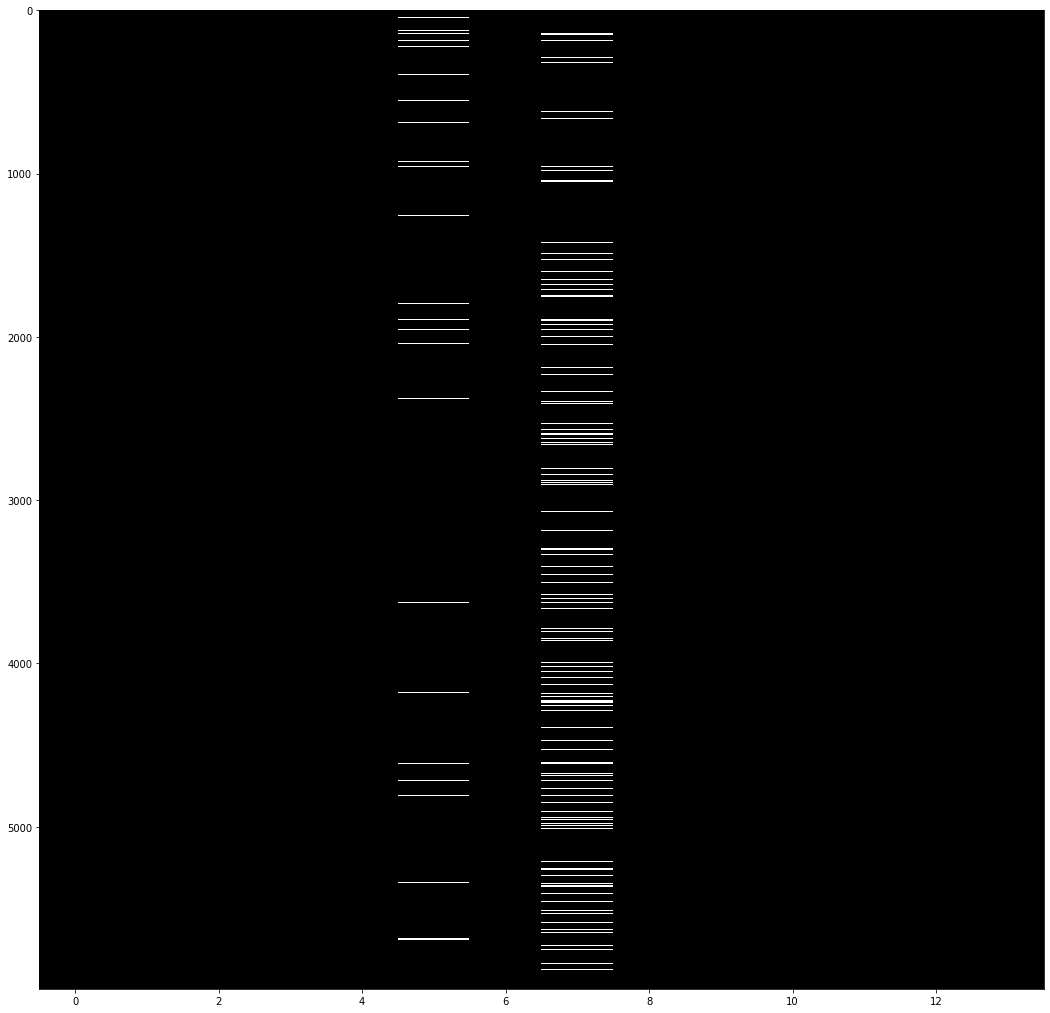

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5313 entries, 0 to 6177
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         5313 non-null   object
 1   Date         5313 non-null   int64 
 2   Rate         5313 non-null   object
 3   Votes        5313 non-null   object
 4   Genre        5313 non-null   object
 5   Duration     5313 non-null   object
 6   Type         5313 non-null   object
 7   Certificate  5313 non-null   object
 8   Episodes     5313 non-null   object
 9   Nudity       5313 non-null   object
 10  Violence     5313 non-null   object
 11  Profanity    5313 non-null   object
 12  Alcohol      5313 non-null   object
 13  Frightening  5313 non-null   object
dtypes: int64(1), object(13)
memory usage: 622.6+ KB
None


In [84]:
data0 = pd.read_csv("data/imdb.csv",
                    delimiter=',',
                   #na_values=['None']
                   )
data0_m = pd.read_csv("data/imdb.csv",
                     delimiter=',',
                     #na_values=['None']
                     )
data0 = data0.drop(data0.index.values[(data0['Rate'] == 'No Rate')])
data0_m = data0_m.drop(data0_m.index.values[(data0_m['Rate'] == 'No Rate')])

print(sum(data0_m['Duration'] == 'None'))
print(sum(data0_m['Certificate'] == 'None'))
print(sum(data0_m['Certificate'] == 'Not Rated'))
print(sum(data0_m['Certificate'] == 'Passed'), "/",sum(data0_m['Certificate'] == 'Approved') )
print(sum(data0_m['Certificate'] == 'Unrated'), "/",sum(data0_m['Certificate'] == 'Not Rated') )

#find the 'hidden' nans for this dataset
data0_m['Duration'] = data0_m['Duration'].replace('None', np.nan)
#https://movies.stackexchange.com/questions/65430/what-are-the-meanings-of-the-terms-passed-and-approved-with-regards-to-a-mov
#what the hell is the difference
data0_m['Certificate'] = data0_m['Certificate'].replace('None', np.nan)
data0_m['Certificate'] = data0_m['Certificate'].replace('Unrated', np.nan)
data0_m['Certificate'] = data0_m['Certificate'].replace('Not Rated', np.nan)
data0_m['Certificate'] = data0_m['Certificate'].replace('Passed', 'Approved')

#replacing stuff
data0_m['Episodes'] = data0_m['Episodes'].replace('-', '1')

"""
TV-Y: Designed to be appropriate for all children

TV-Y7: Suitable for ages 7 and up

G: Suitable for General Audiences
TV-G: Suitable for General Audiences

PG: Parental Guidance suggested
TV-PG: Parental Guidance suggested


PG-13: Parents strongly cautioned. May be Inappropriate for ages 12 and under.
TV-14: Parents strongly cautioned. May not be suitable for ages 14 and under.
M : not recommended for children under the age of 15

R: Restricted. May be inappropriate for ages 17 and under.
TV-MA: For Mature Audiences. May not be suitable for ages 17 and under.
NC-17: Inappropriate for ages 17 and under


TV-G is the same as G which is approved
R and TV-MA is the same
TV-PG, GP, M, TV-MA, R is the same thing
TV-Y is approved
approved is E

"""

certs = np.array(['PG-13',    # X
                  'R',        # X
                  'TV-MA',    # X
                  'TV-14',    # X
                  'TV-PG',    # X
                  'PG',       # X
                  '(Banned)', # this is the last one  as  none should watch it :)
                  'TV-G',     # X
                  'E' ,       # -> 'approved'  , british was of saying it
                  'NC-17',    # X
                  'TV-Y7-FV', # -> TV-Y7
                  'TV-Y7',    # X
                  'Approved', # X this the lowest
                  'G' ,       # X
                  'TV-Y',     # X
                  'GP',       # -> PG
                  'M',        # X
                  'X',        # -> NC-17
                  'M/PG'],    # PG
                 dtype='object')

data0_m['Certificate'] = data0_m['Certificate'].replace(['Approved', 'E'], ['G', 'G'])
data0_m['Certificate'] = data0_m['Certificate'].replace(['TV-G', 'G'], ['G', 'G'])
data0_m['Certificate'] = data0_m['Certificate'].replace(['TV-PG', 'PG', 'GP'], ['PG', 'PG', 'PG'])
data0_m['Certificate'] = data0_m['Certificate'].replace(['R', 'TV-MA', 'NC-17', 'X'], ['R', 'R', 'R', 'R'])
data0_m['Certificate'] = data0_m['Certificate'].replace('TV-G', 'G')
data0_m['Certificate'] = data0_m['Certificate'].replace('TV-Y7-FV', 'TV-Y7')


#how many nans?
fig,ax = plt.subplots(1,1,figsize=(18,18))
ax.imshow(data0_m.isna(), aspect='auto',interpolation='none',cmap="gray")
plt.show()

#dropping nans!
data0 = data0.dropna()
data0_m = data0_m.dropna()

print(data0_m.info())

As it is visible, all of these are strings, which needs some encoding. Let's look at the different columns unique values!

In [96]:
for i in data0.columns:
    typ = pd.unique(data0_m[i].values)
    print("+------------------------------------------------------+\nColumn: \t  {} \n\t{}\n+======================================================+\n".format(i,typ))

+------------------------------------------------------+
Column: 	  Name 
	['No Time to Die' 'The Guilty' 'The Many Saints of Newark' ...
 "Before the Devil Knows You're Dead" 'Queen Bees' 'Death Race']
+======================================================+

+------------------------------------------------------+
Column: 	  Date 
	[2021 2015 2006 2020 2018 2012 1993 1984 2008 1978 2019 1997 2022 1995
 1996 2017 1999 2013 1994 2001 2007 1991 2016 2000 1972 1988 2014 1975
 2005 2009 1981 2002 2010 2004 1980 1962 1982 1992 1998 1969 1990 1985
 2003 1973 1971 1974 1987 2011 1979 1964 1986 1963 1989 1976 1983 1960
 1977 1957 1966 1968 1965 1953 1967 1950 1939 1942 1961 1941 1954 1931
 1958 1946 1959 1956 1945 1951 1937 1952 1970 1940 1955 1949 1933 2023
 1935 1932 1943 1944]
+======================================================+

+------------------------------------------------------+
Column: 	  Rate 
	['7.6' '6.3' '6.4' '8.3' '8.8' '7.3' '8.2' '7.9' '9.2' '8.0' '7.5' '6.8'
 '7.7' '8.

In [69]:
print(len(pd.unique(data0['Genre'].values)))

377


**NAN VALUES**

There are mutliple type of NaN values, like, '-', 'No Rate', 'None'. These could mean different things for each column, so we have to go through what each column means.

Let's go through each column!

**Name**:

No issue here, we don't need any encoding, as the name of the movie/series is an unneeded informtion for our analysis.

**DATE**

This is information that is needed for us.

**RATE**

Target. What we want to predict!

**VOTES**

How many people voted for its rating.

**GENRE**

This has many, but it seems like there are overlappings. Maybe unfolding this into "isSCIFI" columns would be handy...
After checking, we only have like 27 genres, rather then \~400

**DURATION**

Lenght in minutes.

**TYPE**

Is it a movie or series.

**Certificate**

I don't know what are these, but it needs to be encoded.

**EPISODES**

How many episodes it got. Question is how much does it counted if a movie is a trilogy? 

**OTHERS** 

These are just some simple ways to categorize the film.

In [71]:
#preparing stuff
rgx = re.compile("([^,\s]+)")

genres = []
for i in range(len(data0['Genre'].values)):
    gens = rgx.findall(data0['Genre'].values[i])
    genres.append(gens)
    
genres = [item for sublist in genres for item in sublist]

#format the easier rows
data0_m['Votes'] = data0_m['Votes'].replace(to_replace=r'[\,]', value='', regex=True)


#format the genres
genre_list = pd.unique(genres)
my_d = {
    "genre" : genre_list,
    "encode": np.arange(len(genre_list))
}
print((my_d["genre"]))

for i in genres:
    data0_m[i] = copy.deepcopy(np.zeros(len(data0_m.index), dtype=np.uint8))

for i in range(len(data0.index)):
    #data0_m.iloc[2]["War"]
    row = data0['Genre'].values[i]
    gens = rgx.findall(row)
    if len(gens) != 0:
        for j in gens:
            data0_m.at[i,j] = 1
data0_m.info()

['Action' 'Adventure' 'Thriller' 'Crime' 'Drama' 'Sci-Fi' 'Comedy' 'Sport'
 'Animation' 'Horror' 'Mystery' 'Romance' 'History' 'Fantasy' 'Biography'
 'Family' 'Western' 'Musical' 'Music' 'War' 'Short' 'Reality-TV'
 'Documentary' 'Film-Noir' 'Game-Show' 'Talk-Show' 'News']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6145 entries, 0 to 5988
Data columns (total 41 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         5332 non-null   object 
 1   Date         5332 non-null   float64
 2   Rate         5332 non-null   object 
 3   Votes        5332 non-null   object 
 4   Genre        5332 non-null   object 
 5   Duration     5332 non-null   object 
 6   Type         5332 non-null   object 
 7   Certificate  5332 non-null   object 
 8   Episodes     5332 non-null   object 
 9   Nudity       5332 non-null   object 
 10  Violence     5332 non-null   object 
 11  Profanity    5332 non-null   object 
 12  Alcohol      5332 non-null 

In [72]:
#for i in pd.unique(genres):
#    print(i, "\n\t", np.unique(data0_m[i], return_counts=True) )
    

array(['PG-13', 'R', 'TV-MA', 'TV-14', 'TV-PG', 'PG', '(Banned)', 'TV-G',
       'E', 'NC-17', 'TV-Y7-FV', 'TV-Y7', 'Approved', 'G', 'TV-Y', 'GP',
       'M', 'X', 'M/PG'], dtype=object)